In [9]:
import pandas as pd
import numpy as np

DATA_GLUCOSE = '2024-03-23'

 # Import csv data
df = pd.read_csv('Data/Cleaned/Glucose.csv')

# Create datetime from date and time
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Filter data for since the first date we tracked glucose data
df = df[df['datetime'] >= DATA_GLUCOSE]
df = df.sort_values('datetime')

df.tail()


,date,time,glucose,datetime
12538,2024-06-01,06:53:00,108.0,2024-06-01 06:53:00
12539,2024-06-01,06:58:00,110.0,2024-06-01 06:58:00
12540,2024-06-01,07:03:00,109.0,2024-06-01 07:03:00
12541,2024-06-01,07:08:00,109.0,2024-06-01 07:08:00
12542,2024-06-01,07:14:00,114.0,2024-06-01 07:14:00


In [10]:
# Calculate the average glucose and standard deviation for each day
df = df.dropna(subset=['glucose'])
df_d = df.groupby('date').agg({'glucose': ['mean', 'std']}).reset_index()

# Transform the multi-index columns to single index
df_d.columns = ['date', 'mean_glucose', 'std_glucose']

df_d.tail()

,date,mean_glucose,std_glucose
58,2024-05-28,112.086957,20.360158
59,2024-05-29,108.695364,12.192800
60,2024-05-30,113.707071,22.237319
61,2024-05-31,101.154362,8.213666
62,2024-06-01,105.367816,6.561188


In [11]:
# Get wake up time from Whoop API
import os
from dotenv import load_dotenv
from whoop import WhoopClient

# Initialize
load_dotenv("Credentials.env")
un = os.getenv("USERNAME_W")
pw = os.getenv("PASSWORD_W")
client = WhoopClient(un, pw)
profile = client.get_profile()

# Get sleep as pandas dataframe
sleep = client.get_sleep_collection(start_date="2024-01-01")
df_s = pd.json_normalize(sleep)

# Select for not naps
df_s = df_s[df_s['nap'] == False]

# Apply timezone offset
def apply_timezone_offset(row):
    start_time = pd.to_datetime(row['end'])
    hours, minutes = map(int, row['timezone_offset'].split(':'))
    timezone_offset = pd.Timedelta(hours=hours, minutes=minutes)
    return start_time + timezone_offset

df_s['end'] = df_s.apply(apply_timezone_offset, axis=1)

# Adjust datetime format
df_s['end'] = pd.to_datetime(df_s['end'])

# Separate date and time
df_s['day'], df_s['time'] = df_s['end'].dt.date, df_s['end'].dt.time
df_s = df_s[['day', 'time'] + [col for col in df_s.columns if col not in ['day', 'time']]]

# Keep only date and time, rename time to wakeuptime, and drop miliseconds from it
df_s = df_s[['day', 'time']]
df_s = df_s.rename(columns={'time': 'wakeuptime'})
df_s['wakeuptime'] = df_s['wakeuptime'].astype(str).str[:-7]

# If wakeuptime is 0, set 7am
df_s['wakeuptime'] = df_s['wakeuptime'].replace('0', '07:00:00')

In [12]:
df_s.head()

,day,wakeuptime
0,2024-06-01,07:03:56
1,2024-05-31,06:44:29
2,2024-05-30,07:12:30
3,2024-05-29,06:22:43
4,2024-05-28,06:46:54


In [13]:
# Ensure both dataframes have the date on the same format
df['date'] = pd.to_datetime(df['date'])
df_s['day'] = pd.to_datetime(df_s['day'])

# merge df and df_s dataframes by date
df = pd.merge(df, df_s, left_on='date', right_on='day', how='left')
df.tail()

,date,time,glucose,datetime,day,wakeuptime
12538,2024-06-01,06:53:00,108.0,2024-06-01 06:53:00,2024-06-01,07:03:56
12539,2024-06-01,06:58:00,110.0,2024-06-01 06:58:00,2024-06-01,07:03:56
12540,2024-06-01,07:03:00,109.0,2024-06-01 07:03:00,2024-06-01,07:03:56
12541,2024-06-01,07:08:00,109.0,2024-06-01 07:08:00,2024-06-01,07:03:56
12542,2024-06-01,07:14:00,114.0,2024-06-01 07:14:00,2024-06-01,07:03:56


In [14]:
# Create a new dataframe where we only keep the glucose data from the time right after wakeuptime
df = df[df['time'] >= df['wakeuptime']]
df = df.dropna(subset=['glucose'])
df = df.sort_values('datetime')
df.tail()

# Keep only the latest reading for each day
df_w = df.groupby('date').first().reset_index()
df_w = df_w[['date', 'glucose']]
df_w = df_w.rename(columns={'date': 'day', 'glucose': 'wake_up_glucose'})

df_w.tail()


,day,wake_up_glucose
58,2024-05-28,106.0
59,2024-05-29,110.0
60,2024-05-30,103.0
61,2024-05-31,109.0
62,2024-06-01,109.0


In [15]:
# Make sure both dataframes have the same format for date
df_d['date'] = pd.to_datetime(df_d['date'])
df_w['day'] = pd.to_datetime(df_w['day'])

# Merge dt_w back to df_d merging by day/date
df_d = pd.merge(df_d, df_w, left_on='date', right_on='day', how='left')
df_d = df_d.drop(columns=['day'])

df_d

,date,mean_glucose,std_glucose,wake_up_glucose
0,2024-03-23,108.061856,20.013441,108.0
1,2024-03-24,105.467290,19.901322,108.0
2,2024-03-25,95.925620,16.114261,97.0
3,2024-03-26,97.459016,16.181894,94.0
4,2024-03-27,107.873874,14.861859,105.0
...,...,...,...,...
58,2024-05-28,112.086957,20.360158,106.0
59,2024-05-29,108.695364,12.192800,110.0
60,2024-05-30,113.707071,22.237319,103.0
61,2024-05-31,101.154362,8.213666,109.0


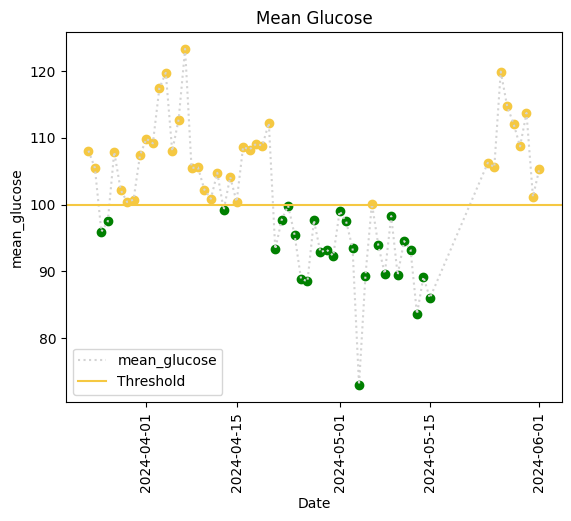

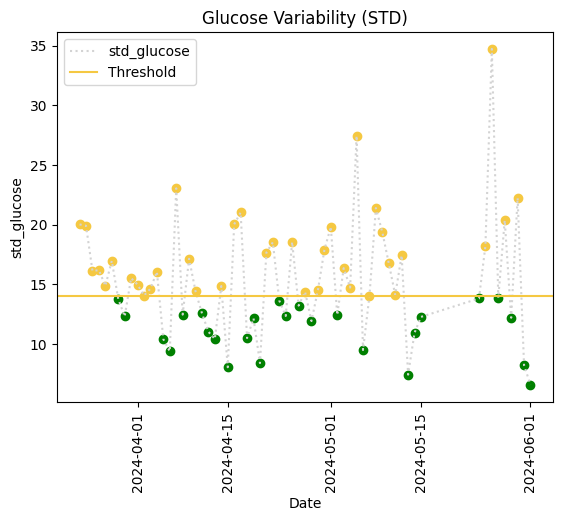

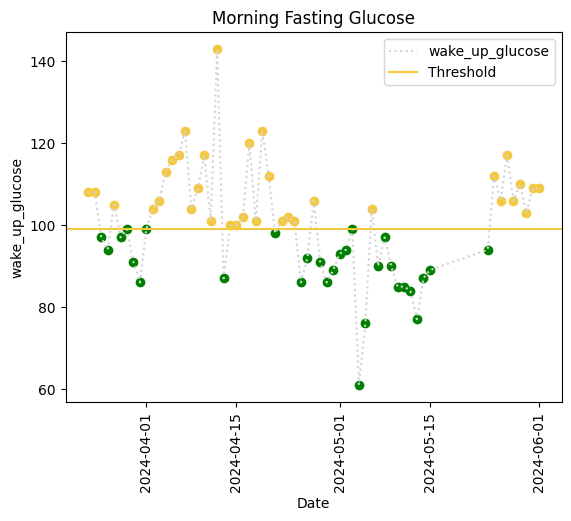

In [16]:
# Define the thressholds for each of the three variables
THRESHOLDS = {
    'mean_glucose': 100,
    'std_glucose': 14,
    'wake_up_glucose': 99
}

# Chart the data
import matplotlib.pyplot as plt


def plot_data(df, variable, threshold, title, y_label):
    fig, ax = plt.subplots()
    # Line between dots: light grey and dotted
    ax.plot(df['date'], df[variable], label=variable, color='lightgrey', linestyle=':')
    # Threshold line: yellow and continuous
    ax.axhline(y=threshold, color='#f5c842', linestyle='-', label='Threshold')
    # Dots below threshold: green
    ax.scatter(df[df[variable] <= threshold]['date'], df[df[variable] <= threshold][variable], color='green')
    # Dots above threshold: yellow
    ax.scatter(df[df[variable] > threshold]['date'], df[df[variable] > threshold][variable], color='#f5c842')
    # Update chart and Y-axis titles
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel(y_label)
    # Rotate dates for better readability
    plt.xticks(rotation='vertical')
    ax.legend()
    plt.show()

titles = {
    'mean_glucose': "Mean Glucose",
    'std_glucose': "Glucose Variability (STD)",
    'wake_up_glucose': "Morning Fasting Glucose",
}

for variable, threshold in THRESHOLDS.items():
    plot_data(df_d, variable, threshold, titles[variable], variable)

